Seeding for reproducibility

In [ ]:
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

Importing Dependencies


In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models

Data Curation

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentials=json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY']=kaggle_credentials["key"]

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:21<00:00, 32.2MB/s]
100% 2.04G/2.04G [01:21<00:00, 26.7MB/s]


In [ ]:
!ls

 kaggle.json  'plantvillage dataset'   plantvillage-dataset.zip   sample_data


In [ ]:
with ZipFile("plantvillage-dataset.zip",'r') as zip_ref:
  zip_ref.extractall()

Data Preprocessing

In [ ]:
base_dir="plantvillage dataset/color"

In [ ]:
img_size=224
batch_size=32

Train Test Split

In [ ]:
data_gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [ ]:
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


CNN

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)              

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

Model Training

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples //batch_size
)

Epoch 1/5
1358/1358 [==============================] - 134s 95ms/step - loss: 0.9772 - accuracy: 0.7332 - val_loss: 0.4944 - val_accuracy: 0.8454
Epoch 2/5
1358/1358 [==============================] - 106s 78ms/step - loss: 0.2884 - accuracy: 0.9084 - val_loss: 0.3695 - val_accuracy: 0.8838
Epoch 3/5
1358/1358 [==============================] - 129s 95ms/step - loss: 0.1341 - accuracy: 0.9559 - val_loss: 0.5164 - val_accuracy: 0.8603
Epoch 4/5
1358/1358 [==============================] - 106s 78ms/step - loss: 0.0893 - accuracy: 0.9706 - val_loss: 0.5539 - val_accuracy: 0.8750
Epoch 5/5
1358/1358 [==============================] - 110s 81ms/step - loss: 0.0637 - accuracy: 0.9797 - val_loss: 0.6742 - val_accuracy: 0.8621


Model Evaluation

In [ ]:
print("Evaluating model...")
val_loss,val_accuracy=model.evaluate(validation_generator,steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Evaluating model...
339/339 [==============================] - 18s 54ms/step - loss: 0.6742 - accuracy: 0.8621
Validation Accuracy: 86.21%


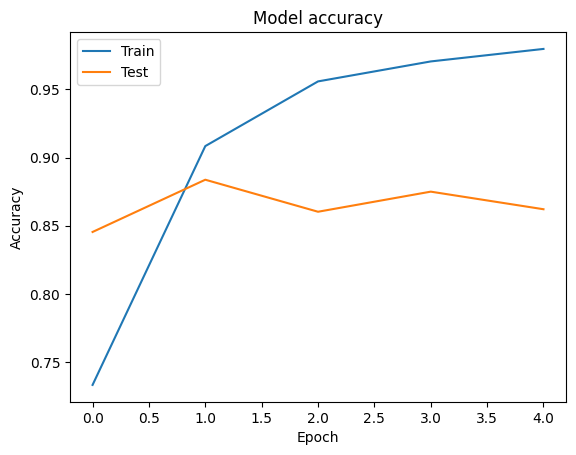

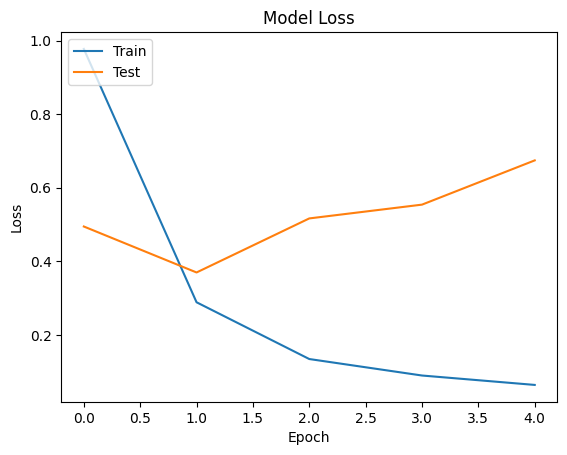

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend({'Train','Test'},loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend({'Train','Test'},loc='upper left')
plt.show()

Predictive System

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.0
    return img_array

def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
class_indices = {v:k for k,v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
json.dump(class_indices,open('class_indices.json','w'))

In [ ]:
image_path='/content/appleblack.jpeg'
predicted_class_name=predict_image_class(model,image_path,class_indices)
print('Predicted Class Name:',predicted_class_name)

1/1 [==============================] - 0s 420ms/step
Predicted Class Name: Apple___Black_rot


Save the model

In [ ]:
from google.colab import drive
drive.mount('/mnt/drive')
import os

save_dir = '/mnt/drive/MyDrive/trained_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'plant_disease_classifier.h5'))


Mounted at /mnt/drive
